## Import Libraries

In [1]:
import torch
import torch.nn as nn
import zipfile
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import torchvision.models as models
from torchvision.models import ResNet18_Weights
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split
import numpy as np
import tqdm

## Using Seed for Replication

In [2]:
# Seed para replicar o modelo
SEED = 42
import random
random.seed(SEED)
np.random.seed(SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

## Using Transforms and Loading Datasets

In [3]:
# Definir transformações
transformacao = transforms.Compose([
    transforms.Resize((190, 190)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

# Carregar datasets
base_treinamento = datasets.ImageFolder(root='USK-Coffee/train', transform=transformacao)
train_dataloader = DataLoader(base_treinamento, batch_size=10, shuffle=True)

base_validacao = datasets.ImageFolder(root='USK-Coffee/val', transform=transformacao)
validation_dataloader = DataLoader(base_validacao, batch_size=10, shuffle=True)

base_teste = datasets.ImageFolder(root='USK-Coffee/test', transform=transformacao)
test_dataloader = DataLoader(base_teste, batch_size=1, shuffle=False)


## Creating Arquitecture

In [5]:
# Carregar modelo ResNet-18 pré-treinado com pesos atualizados
model = models.resnet18(weights='IMAGENET1K_V1')  # ou ResNet18_Weights.DEFAULT dependendo do seu ambiente

# Modificar a camada final para binária (sem sigmoid aqui)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)  # A saída é um único valor para a tarefa binária

# Definir dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(device)


cuda


## Def Acc, Train and Evaluate Functions

In [6]:
def accuracy(outputs, labels):
    # Aplicando sigmoid para obter probabilidades
    prob = torch.sigmoid(outputs)  # Para uma tarefa binária
    predicted = torch.round(prob)  # Arredondando para 0 ou 1
    correct = (predicted == labels).float()
    acc = correct.sum() / len(correct)
    return acc


# Usando BCEWithLogitsLoss para lidar com logits diretamente
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# Função de treinamento
def train(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_accuracy += accuracy(outputs, labels.unsqueeze(1).float()).item() * inputs.size(0)
    epoch_loss = running_loss / len(loader.dataset)
    epoch_accuracy = running_accuracy / len(loader.dataset)
    return epoch_loss, epoch_accuracy

# Função de avaliação
def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    running_accuracy = 0.0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            running_loss += loss.item() * inputs.size(0)
            running_accuracy += accuracy(outputs, labels.unsqueeze(1).float()).item() * inputs.size(0)
    epoch_loss = running_loss / len(loader.dataset)
    epoch_accuracy = running_accuracy / len(loader.dataset)
    return epoch_loss, epoch_accuracy


## Def Checkpoint functions

In [7]:
class CustomModelCheckpoint:
    def __init__(self):
        self.best_val_accuracy = 0.0

    def __call__(self, epoch, val_accuracy, model, optimizer, loss):
        if val_accuracy > self.best_val_accuracy:
            print(f"Validation accuracy improved from {self.best_val_accuracy:.4f} to {val_accuracy:.4f}. Saving model...")
            self.best_val_accuracy = val_accuracy
            save_checkpoint(epoch, model, optimizer, loss)
            # Também salva o melhor modelo com um nome fixo
            save_best_model(model, optimizer, loss)

# Função para salvar checkpoint
def save_checkpoint(epoch, model, optimizer, loss):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }
    torch.save(checkpoint, checkpoint_path.format(epoch=epoch))

# Função para salvar o melhor modelo
def save_best_model(model, optimizer, loss):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }
    torch.save(checkpoint, best_model_path)

# Configurações de checkpoint
checkpoint_dir = "modelos/pesos_Resnet18++"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, 'cp2-{epoch:04d}.pth')
best_model_path = os.path.join(checkpoint_dir, 'Melhor_modelo_Resnet18++.pth')
cp_callback = CustomModelCheckpoint()

## Training Model

In [8]:
# Listas para guardar os valores de acuracia e loss do modelo
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

epochs = 100  # mudar para a quantidade de épocas que desejar

for epoch in range(epochs):
    train_loss, train_accuracy = train(model, train_dataloader, optimizer, criterion)
    val_loss, val_accuracy = evaluate(model, validation_dataloader, criterion)

    # Adiciona loss e acurácia de treinamento e validação de cada época em uma lista
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
    cp_callback(epoch, val_accuracy, model, optimizer, val_loss)


C:\Users\marcu\anaconda3\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 1/100, Train Loss: 0.3491, Train Acc: 0.8571, Val Loss: 0.8678, Val Acc: 0.6250
Validation accuracy improved from 0.0000 to 0.6250. Saving model...
Epoch 2/100, Train Loss: 0.2303, Train Acc: 0.9150, Val Loss: 0.3225, Val Acc: 0.8725
Validation accuracy improved from 0.6250 to 0.8725. Saving model...
Epoch 3/100, Train Loss: 0.2181, Train Acc: 0.9188, Val Loss: 0.5372, Val Acc: 0.7950
Epoch 4/100, Train Loss: 0.1751, Train Acc: 0.9367, Val Loss: 0.3590, Val Acc: 0.8688
Epoch 5/100, Train Loss: 0.1658, Train Acc: 0.9354, Val Loss: 0.5261, Val Acc: 0.7613
Epoch 6/100, Train Loss: 0.1696, Train Acc: 0.9358, Val Loss: 0.3123, Val Acc: 0.8775
Validation accuracy improved from 0.8725 to 0.8775. Saving model...
Epoch 7/100, Train Loss: 0.0881, Train Acc: 0.9683, Val Loss: 0.3225, Val Acc: 0.8750
Epoch 8/100, Train Loss: 0.1033, Train Acc: 0.9629, Val Loss: 0.3448, Val Acc: 0.8600
Epoch 9/100, Train Loss: 0.1111, Train Acc: 0.9621, Val Loss: 0.4878, Val Acc: 0.8163
Epoch 10/100, Train Lo

## Plotting Acc and Loss Graphics

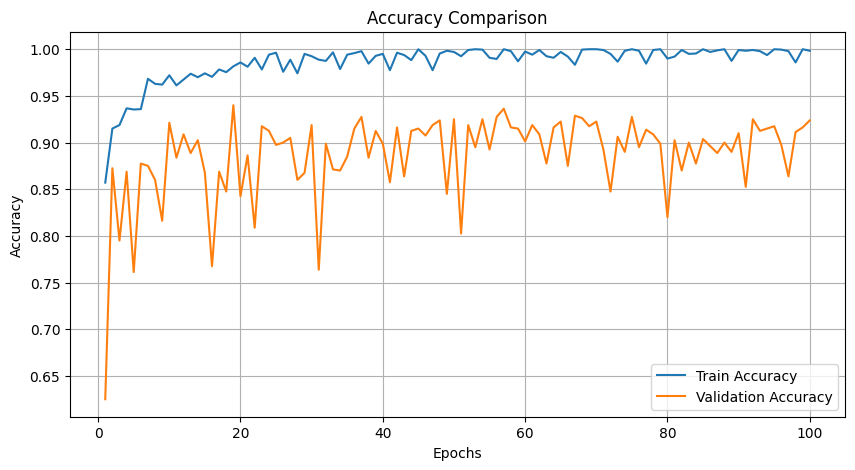

In [9]:
# Plotar acurácia
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.legend()
plt.grid(True)
output_dir = 'gráficos/Gráficos Resnet18++'
os.makedirs(output_dir, exist_ok=True)
plt.savefig(os.path.join(output_dir, f'accuracy_comparison.pdf'))
plt.show()

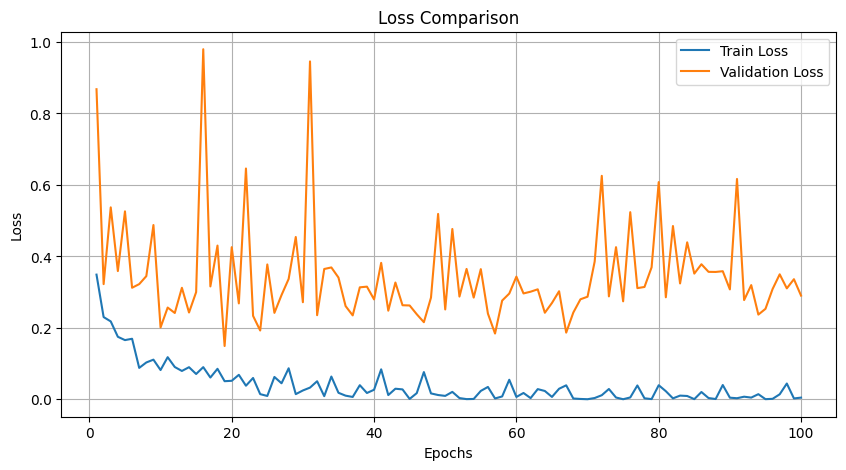

In [10]:
# Plotar perda
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Comparison')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(output_dir, f'loss_comparison.pdf'))
plt.show()

## Testing Best Model

In [13]:
from torch.utils.data import DataLoader, Subset

# Definir transformações
transformacao = transforms.Compose([
    transforms.Resize((190, 190)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

# Carregar datasets
base_treinamento = datasets.ImageFolder(root='USK-Coffee/train', transform=transformacao)
train_dataloader = DataLoader(base_treinamento, batch_size=10, shuffle=True)

base_validacao = datasets.ImageFolder(root='USK-Coffee/val', transform=transformacao)
validation_dataloader = DataLoader(base_validacao, batch_size=10, shuffle=True)

base_teste = datasets.ImageFolder(root='USK-Coffee/test', transform=transformacao)
test_dataloader = DataLoader(base_teste, batch_size=1, shuffle=False)



# Carregar modelo ResNet-18 pré-treinado
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)

# Modificar a camada final para binária (sem sigmoid aqui)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)  # A saída é um único valor para a tarefa binária


# Definir dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(device)

# Carregar pesos do modelo pré-treinado
checkpoint = torch.load('modelos/pesos_Resnet18++/Melhor_modelo_Resnet18++.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Avaliar o modelo
val_loss, val_accuracy = evaluate(model, validation_dataloader, criterion)
print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}") # conferir se bateu com a melhor acurácia


cuda
Val Loss: 0.1493, Val Acc: 0.9400


# Testing Model

In [15]:
model.eval()

y_true = []
y_pred = []
y_scores = []

with torch.no_grad():  # desativa a mudança do modelo
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        
        # Aplica sigmoid para obter probabilidades
        probs = torch.sigmoid(outputs).squeeze().cpu().numpy()
        
        # Arredonda para 0 ou 1 para predição
        predicted = torch.round(torch.sigmoid(outputs)).squeeze().cpu().numpy()

        # Adiciona os valores de verdade e predições
        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.tolist())
        y_scores.append(probs.tolist())
    
    # Avaliação do modelo
    test_loss, test_accuracy = evaluate(model, test_dataloader, criterion)
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}")

Test Loss: 0.3356, Test Acc: 0.8762


## Plotting Confusion Matrix and Precision Recall Graphic

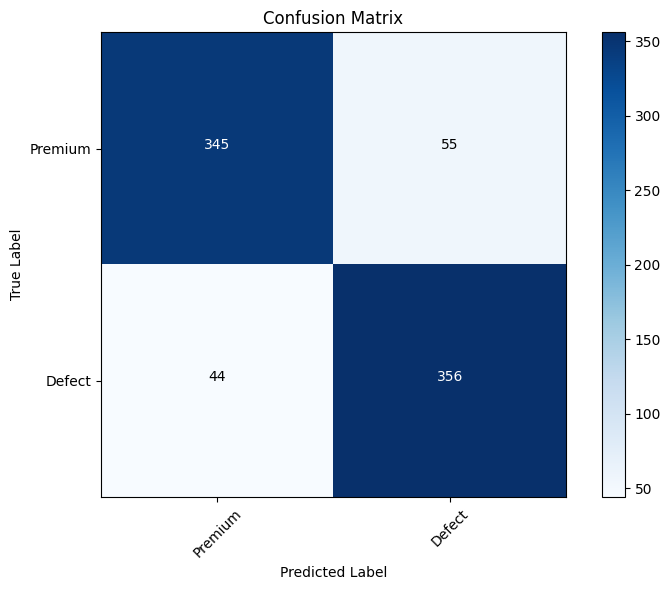

In [16]:
# Matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Premium', 'Defect'], rotation=45)
plt.yticks(tick_marks, ['Premium', 'Defect'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, f'confusion_matrix.pdf'))
plt.show()

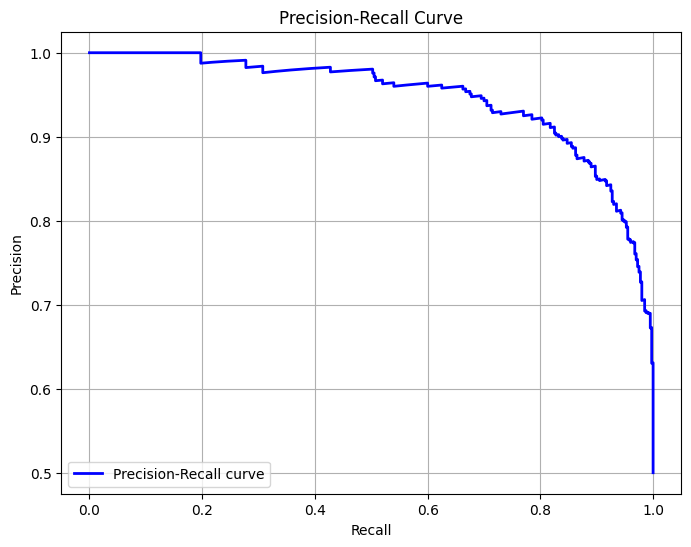

Melhor pontuação F1: 0.8820023837902266
Valor de recall no ponto F1 máximo: 0.925


In [17]:
from sklearn.metrics import precision_recall_curve, f1_score

# precision_recall_curve retorna precisão, recall e os thresholds
precision, recall, _ = precision_recall_curve(y_true, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)

# Calcula a pontuação F1
f1 = 2 * (precision * recall) / (precision + recall)

# Encontre o índice do ponto de F1 máximo
idx = np.argmax(f1)

# Extrair o melhor valor de recall no ponto de F1 máximo
best_f1 = f1[idx]
best_recall = recall[idx]

plt.savefig(os.path.join(output_dir, f'Precision-Recall.pdf'))

plt.show()

# Exibe a melhor pontuação F1 e o valor de recall correspondente
print("Melhor pontuação F1:", best_f1)
print("Valor de recall no ponto F1 máximo:", best_recall)